In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import os
import sys
import numpy as np
from torchvision import transforms as T
from torchvision.io import read_image
import matplotlib.ticker as mtick
import io
from IPython.display import clear_output, display
import PIL.Image as Image
import matplotlib.ticker as mticker
from torchcam.utils import overlay_mask
import zipfile
from torchinfo import summary
#from torch_snippets import *
import torchvision.models as models
import selectivesearch
from torchcam.methods import SmoothGradCAMpp, CAM, ScoreCAM
from torch.optim import Adam, SGD
from time import sleep
import h5py as h5
import torch.nn.functional as FW
import random

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
train_x = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_x"])

In [5]:
train_y = np.array(h5.File("Signs_Data_Training.h5", "r")["train_set_y"])

In [6]:
test_x = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_x"])

In [7]:
test_y = np.array(h5.File("Signs_Data_Testing.h5", "r")["test_set_y"])

In [8]:
train_data_p = "data/fingers/train"

In [9]:
test_data_p = "data/fingers/test"

#### Reading data

In [10]:
class HandDataset(Dataset):
    def __init__(self, train_p=None, dat=None, train=True, transform=None, one_hot=False, zipf=False):
        
        assert (train_p is not None and dat is None) or (train_p is None or dat is not None)
        
        if train_p is not None:
            self._train_p = train_p
            self._one_hot = one_hot
            self._train = train
            self._zipf = zipf
            self._train_x, self._train_y = self.__get_tensors()
        else:
            self._train_x, self._train_y = dat
    
    def __get_tensors(self):   
        if self._zipf:
            zf = zipfile.ZipFile(self._train_p, "r")
            if self._train:
                train_files = [i for i in zf.namelist() if ("train" in i) and (i.endswith("png"))]
            else:
                train_files = [i for i in zf.namelist() if ("test" in i) and (i.endswith("png"))]
            
            train_x = torch.stack(tuple(torch.from_numpy(self.__read_io_np(zf, f)) for f in train_files))
                
        else:
            train_files = [os.path.join(os.getcwd(), self._train_p, d) for d in os.listdir(self._train_p)]
            train_x = torch.stack(tuple(read_image(f) for f in train_files))
                
        if self._one_hot:  
            train_y = F.one_hot(torch.Tensor([int(f[-6]) for f in train_files]).long(), 6)
        else:
            train_y = torch.Tensor([int(f[-6]) for f in train_files]).long()
            
        return train_x, train_y
            
    
    def __read_io_np(self, zf, f):
        return np.array(Image.open(io.BytesIO(bytearray(zf.read(f)))))
        
        return train_x, train_y
    
    def __len__(self):
        return len(self._train_x)
    
    def __getitem__(self, idx):
        if transform:
            return torch.squeeze(transform(self._train_x[idx])), self._train_y[idx]
        return self._train_x, self._train_y
    
  

In [11]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [12]:
transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    #T.Grayscale(),
    T.Lambda(lambda x: x.repeat(3, 1, 1)),
    T.Normalize(mean=MEAN, std=STD)
]
)

In [13]:
# train_ds = HandDataset(dat=(train_x, train_y), train=True, transform=transform, one_hot=False, zipf=True)

In [14]:
# test_ds = HandDataset(dat=(test_x, test_y), train=False, transform=transform, one_hot=False, zipf=True)

In [15]:
train_ds = HandDataset(train_p=train_data_p, train=True, transform=transform, one_hot=False, zipf=False)

In [16]:
test_ds = HandDataset(train_p=test_data_p, train=False, transform=transform, one_hot=False, zipf=False)

#### Visualization

In [17]:
r_images = [random.randint(1, 500) for _ in range(9)]

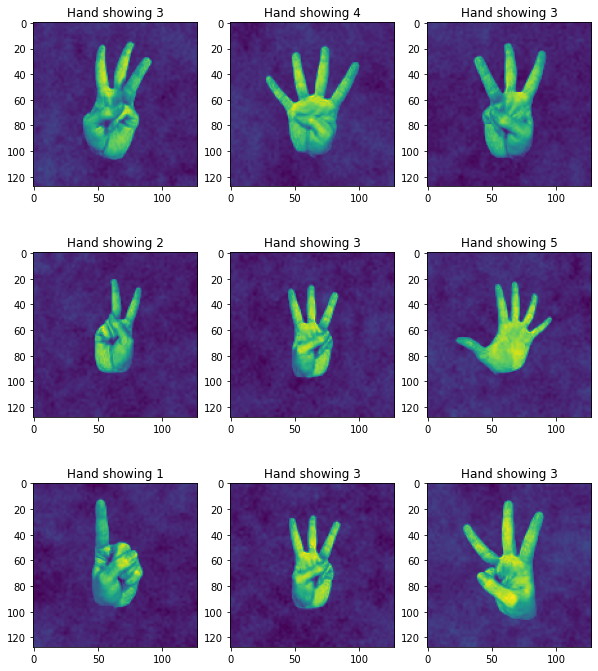

In [18]:
fig, axe = plt.subplots(3, 3, figsize=(10, 12))
c = 0
for i in range(3):
    for j in range(3):
        axe[i, j].imshow(train_ds[r_images[c]][0][0])
        axe[i, j].set_title("Hand showing {}".format(train_ds[r_images[c]][1]))
        c += 1

#### Functions

In [19]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if (r["rect"] in candidates) or (r["size"] < (0.05 * img_area)) or (r["size"] > (1 * img_area)): 
            continue 
        candidates.append(list(r["rect"]))
    return candidates

In [20]:
def get_cam(tensor, model, layer="features"):
    model.eval()
    tensor = tensor.to(device)
    try:
        cam = ScoreCAM(model, target_layer=layer)
    except ValueError:
        cam = SmoothGradCAMpp(model)
    out = model(tensor.unsqueeze(0))
    activation_map = cam(out.squeeze(0).argmax().item(), out)
    result = overlay_mask(T.functional.to_pil_image(tensor), T.functional.to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    plt.imshow(result); plt.tight_layout(); plt.axis('off'); plt.show()

In [21]:
def train_batch(x, y, model, opt, loss):
    opt.zero_grad()
    model.train()
    pred = model(x)
    bloss = loss(pred, y)
    bloss.backward()
    opt.step()
    
    return bloss.item()

In [22]:
@torch.no_grad()
def accuracy(x, y, model):
    pred = model(x)
    correct = torch.argmax(pred, dim=1) == y
    return correct.cpu().numpy().tolist()

In [23]:
@torch.no_grad()
def test_loss(x, y, model, loss):
    pred = model(x)
    tloss = loss(pred, y)
    return tloss.item()

In [24]:
def get_model(name="alexnet", freeze=True):
    assert name in ("alexnet", "densenet", "resnet")
    
    if name == "alexnet":
        model = models.alexnet(pretrained=True)
        if freeze:
            for l in model.features:
                for p in l.parameters():
                    p.requires_grad = False
        model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=6, bias=True)
    
    elif name == "densenet":
        model = models.densenet121(pretrained=True)
        if freeze:
            for l in model.features:
                for p in l.parameters():
                    p.requires_grad = False
        model.classfier = nn.Linear(in_features=model.classifier.in_features, out_features=6, bias=True)
    
    elif name == "resnet":
        model = models.resnet18(pretrained=True)
        if freeze:
            count = 0
            for c in model.children():
                if count < 10:
                    for p in c.parameters():
                        p.requires_grad = False
                count += 1
        model.fc = nn.Linear(in_features = model.fc.in_features, out_features=6, bias=True)
    
    model = model.to(device)
    return model
            
        

#### Training

In [25]:
model = get_model("alexnet", freeze=True)

In [26]:
train_batchs = 128

In [27]:
test_batchs = 32

In [28]:
train_loader = DataLoader(train_ds, train_batchs, shuffle=True)

In [29]:
test_loader = DataLoader(test_ds, test_batchs, shuffle=True)

In [30]:
num_epoch = 5

In [31]:
opt = Adam(model.parameters(), lr=0.001)

In [32]:
loss = nn.CrossEntropyLoss()

In [33]:
#log = Report(num_epoch)

In [34]:
def train_mod(train_ld, test_ld, model, loss, opt, ne):
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    range_ep = range(ne)
    with tqdm(total=len(range_ep), file=sys.stdout) as pbar:
        for ep in range_ep:
            train_ep_loss, train_ep_acc = [], []
            val_ep_acc = []
            c = 0
            len_load = len(train_ld)
            len_tload = len(test_ld)
    #         print("Training...")
            for idx, batch in enumerate(iter(train_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                bloss = train_batch(im, label, model, opt, loss)
                train_ep_loss.append(bloss)

                pos = (ep + (idx + 1) / len_load)

            c_loss = np.mean(train_ep_loss)
            train_loss.append(c_loss)

            #log.record(pos, train_loss=c_loss, end='\r')

            #print("Train loss: {} \n".format(c_loss))

            #print("Testing accuracy on train ...")
            for idx, batch in enumerate(iter(train_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                correct = accuracy(im, label, model)

                train_ep_acc.extend(correct)

                pos = (ep + (idx + 1) / len_load)

            c_acc1 = np.mean(train_ep_acc)
            train_acc.append(c_acc1)

            #log.record(pos, train_acc=c_acc1, end='\r')

            #print("Train acc: {} \n".format(c_acc1))

            for idx, batch in enumerate(iter(test_ld)):
                im, label = batch
                im = im.to(device)
                label = label.to(device)

                correct = accuracy(im, label, model)
                val_ep_acc.extend(correct)

                pos = (ep + (idx + 1) / len_tload)

            c_acc2 = np.mean(val_ep_acc)
            val_acc.append(c_acc2)
            #log.record(pos, test_acc=c_acc2, end='\r')

                #print("Test acc: {}".format(c_acc2))

            pbar.set_description("Train loss: {:.2f} Train Acc: {:.2f} Test Acc: {:.2f} \n".format(c_loss, c_acc1, c_acc2))
            pbar.update(1)
    return train_loss, train_acc, val_acc

        

In [35]:
ne = 5

In [36]:
train_loss, train_acc, val_acc = train_mod(train_loader, test_loader, model, loss, opt, ne)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
range_ep = list(range(ne))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(range_ep, train_loss)
axes[1].plot(range_ep, train_acc)
axes[1].plot(range_ep, val_acc)
axes[0].legend(["Training loss"])
axes[1].legend(["Training accuracy", "Test accuracy"])

In [ ]:
# c = 0
# for i in range(3):
#     for j in range(3):
#         get_cam(train_ds[r_images[c]][0], model=model)
#         c += 1